<h1 style="color:#2F659C";>Beorn D2 measurement script</h1>
This notebook can be used to start a new measurement. It includes all the imports and instrument initializations, which can then be removed according to the measurement necessities. A small description of the Chip can be added here, and it is a good practice to change the sample name accordingly.

In [1]:
sample_name = 'beorn_d2'  # name of the chip in the fridge
user = 'sc-ncr'             # who is performing measurements

# date = '20220620'        # when did the measurements started
# description = 's21_meas'   # super short description of what you are doing

date = '20220620'        # when did the measurements started
description = 'chip_characterisation'   # super short description of what you are doing

# date = '20220608'        # when did the measurements started
# description = 'iv_curves'   # super short description of what you are doing

<h3 style="color:#418FDB";>QCodes imports</h3>
Import the QCodes functions used in the measurement of this sample.

In [2]:
import os
import sys
from time import sleep, perf_counter
import json
import matplotlib.pyplot as plt
import numpy as np
import tqdm.notebook as tqdm
import qcodes as qc
import time
from qcodes import (
    Measurement,
    experiments,
    initialise_database,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_experiment,
    load_last_experiment,
    load_or_create_experiment,
    new_experiment,
    validators
)
from qcodes.instrument.parameter import Parameter

#from qcodes.utils.dataset.doNd import do0d, do1d, do2d, dond, plot, LinSweep, LogSweep

from qcodes.dataset.plotting import plot_dataset
from qcodes.logger.logger import start_all_logging, start_command_history_logger
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement
from qcodes.interactive_widget import experiments_widget

In [3]:
sys.path.append(r'C:\Users\nicolas.roch\Measurements\Scripts')

from QMETfunc.QMET_measurement import do0d, do1d, do2d, dond, LinSweep, LogSweep

<h2 style="color:#1C3C5C";>Station and database setup</h2>
Add the instruments to the station and start all the loggings related to the measurement. Then create or initialise the database where all the data will be saved.

In [4]:
data_dir = os.path.join(r'D:\QMET' + '\\' + sample_name)

<h3 style="color:#418FDB";>Database initialization</h3>

In [5]:
database_name = date + '_' + user + '_' + description
try :
    os.mkdir(data_dir)
except FileExistsError:
    pass

qc.initialise_or_create_database_at(data_dir + '\\' + database_name + '.db')
qc.config.core.db_location

'D:\\QMET\\beorn_d2\\20220620_sc-ncr_chip_characterisation.db'

<h3 style="color:#418FDB";>Station initialization</h3>

In [6]:
STATION = qc.Station()

start_all_logging()
start_command_history_logger(data_dir)

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nicolas.roch\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nicolas.roch\.qcodes\logs\220622-18752-qcodes.log
Activating auto-logging. Current session state plus future input saved.
Filename       : D:\QMET\beorn_d2\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


<h3 style="color:#418FDB";>Instruments initialisation</h3>
Add to path the folder containing the drivers. Then import and connect to the used instruments, while delete the unused ones.

In [7]:
sys.path.append(r'C:\Users\nicolas.roch\Measurements\Drivers')

<h4 style="color:#4697E8";>Connect to the ADwin</h4>

In [8]:
from ADwin_Gold2 import ADwin_Gold2, ADwin_ramp, ADwin_averagedRamp, ADwin_IV,  ADwin_VI
ADwin_Gold2.close_all()
ad = ADwin_Gold2("adwin",
                 r"C:\Users\nicolas.roch\Measurements\Drivers\adwin\nanoqt\ressources\ADwin11.btl",
                 r"C:\Users\nicolas.roch\Measurements\Drivers\adwin\nanoqt\ressources\acquisition-gold2.TB1")

Connected to: None adwin (serial:None, firmware:None) in 0.25s


<h4  style="color:#4697E8";>Connect to the Rohde&Schwartz VNA</h4>

In [9]:
from VNA_RS import ZNB
#from VNA_ZNB20 import ZNB
#from VNA_ZNB20 import ZNBChannel

try:
    vna = ZNB('ZNB20', 'TCPIP0::192.168.0.9::inst0::INSTR',
               init_s_params=False,terminator='\n')
except KeyError as er:
    ZNB.close_all() # Disconnect and irreversibly tear down the instrument
    vna = ZNB('ZNB20', 'TCPIP0::192.168.0.9::inst0::INSTR',
               init_s_params=False,terminator='\n')
    
vna.clear_channels()

vna.add_channel('S21', vna_parameter='S21');
s21 = vna.channels.S21

#vna.add_channel('S11', vna_parameter='S11');
#s11 = vna.channels.S11

Connected to: Rohde-Schwarz ZNB20-2Port (serial:1311601062101579, firmware:2.94) in 0.09s


<h4 style="color:#4697E8";>Connect to the Agilent signal generator</h4>

In [10]:
from Agilent_E8257D import E8257D

try:
    mw_source = E8257D('mw_source','TCPIP0::192.168.0.70::inst0::INSTR')
except KeyError as er:
    E8257D.close_all()
    mw_source = E8257D('mw_source','TCPIP0::192.168.0.70::inst0::INSTR')

Connected to: Agilent Technologies E8257D (serial:US45470698, firmware:C.06.28) in 0.04s


<h4 style="color:#4697E8";>Connect to the Rohde&Schwartz signal generator</h4>

In [11]:
from RS_SMB_100A import SMB100A

#try:
#    mw_source_rs = SGS100A('pump_source','USB0::0x0AAD::0x0088::112061::INSTR')
#except KeyError as er:
#    SGS100A.close_all()
#    mw_source_rs = SGS100A('pump_source','USB0::0x0AAD::0x0088::112061::INSTR')

<h4 style="color:#4697E8";>Connect to the HP3245A current generator</h4>

In [12]:
from HP3245A import HP3245A

try:
    I_source = HP3245A('current_source', 'GPIB0::9::INSTR')

except KeyError as er:
    HP3245A.close_all() #Disconnect and irreversibly tear down the instrument
    I_source = HP3245A('current_source', 'GPIB0::9::INSTR')
I_source.output_terminal('REAR')

Connected to: HEWLETT PACKARD None (serial:None, firmware:None) in 0.13s


<h4 style="color:#4697E8";>Connect to the SR830 lock-in amplifier</h4>

In [13]:
from qcodes.instrument_drivers.stanford_research.SR830 import SR830

try:
    li = SR830('lockin', 'GPIB0::14::INSTR')

except KeyError as er:
    SR830.close_all() #Disconnect and irreversibly tear down the instrument
    li = SR830('lockin', 'GPIB0::14::INSTR')

2022-06-22 15:15:16,180 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 109 ¦ C:\Users\nicolas.roch\Miniconda3\envs\measurement\lib\site-packages\qcodes\instrument\base.py:128: QCoDeSDeprecationWarning: Parameter ch1_databuffer on instrument lockin does not correctly pass kwargs to its baseclass. A Parameter class must take `**kwargs` and forward them to its baseclass.
  warnings.warn(

2022-06-22 15:15:16,206 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 109 ¦ C:\Users\nicolas.roch\Miniconda3\envs\measurement\lib\site-packages\qcodes\instrument\base.py:128: QCoDeSDeprecationWarning: Parameter ch2_databuffer on instrument lockin does not correctly pass kwargs to its baseclass. A Parameter class must take `**kwargs` and forward them to its baseclass.
  warnings.warn(



Connected to: Stanford_Research_Systems SR830 (serial:s/n22820, firmware:ver1.01) in 0.10s


<h4 style="color:#4697E8";>Connect to the FSV3030 spectrum analyser</h4>

In [14]:
from RS_FSV import RS_FSV

#try:
#    spectrum_analyser = RS_FSV('spectrum_analyser', 'TCPIP0::192.168.0.66::inst0::INSTR')

#except KeyError as er:
#    RS_FSV.close_all() #Disconnect and irreversibly tear down the instrument
#    spectrum_analyser = RS_FSV('spectrum_analyser', 'TCPIP0::192.168.0.66::inst0::INSTR')

<h4 style="color:#4697E8";>Connect to the Signal Hound spectrum analyser</h4>

In [15]:
# from SignalHound_USB_SA124B import SignalHound_USB_SA124B
# # SignalHound_USB_SA124B.close_all()
# sh = SignalHound_USB_SA124B('signal_hound2', dll_path='C:\\Program Files\\Signal Hound\\Spike\\sa_api.dll')

<h4 style="color:#4697E8";>Connect to the AFG3252 arbitrary function generator</h4>

In [16]:
from qcodes_contrib_drivers.drivers.Tektronix.AFG3000 import AFG3000 

try:
    afg = AFG3000('function_generator', 'TCPIP0::192.168.0.12::inst0::INSTR')

except KeyError as er:
    AFG3000.close_all() # Disconnect and irreversibly tear down the instrument
    afg = AFG3000('function_generator', 'TCPIP0::192.168.0.12::inst0::INSTR')

Connected to: TEKTRONIX AFG3252 (serial:C011080, firmware:SCPI:99.0 FV:1.2.1) in 4.08s


<h4 style="color:#4697E8";>Dummies</h4>

In [17]:
# dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
# dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

<h3 style="color:#418FDB";>Adding the instruments to the station</h3>

In [18]:
STATION.add_component(s21)         # VNA channel s21
STATION.add_component(mw_source)   # Signal generator
STATION.add_component(ad)          # ADwin
STATION.add_component(I_source)
STATION.add_component(li)
# STATION.add_component(sh)
STATION.add_component(afg)

#STATION.add_component(daq)        # Dummy signal
#STATION.add_component(dmm)        # Dummy multimeter

STATION.snapshot();
STATION.components

2022-06-22 15:15:21,367 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 259 ¦ [ZNB20_S21(VNAChannel)] Snapshot: Could not update parameter: trigger_link
2022-06-22 15:15:26,494 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 259 ¦ [mw_source(E8257D)] Snapshot: Could not update parameter: sweepmode
2022-06-22 15:15:26,523 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 259 ¦ [adwin(ADwin_Gold2)] Snapshot: Could not update parameter: outputs
2022-06-22 15:15:26,526 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 259 ¦ [adwin(ADwin_Gold2)] Snapshot: Could not update parameter: inputs


{'ZNB20_S21': <VNAChannel: ZNB20_S21 of ZNB: ZNB20>,
 'mw_source': <E8257D: mw_source>,
 'adwin': <ADwin_Gold2: adwin>,
 'current_source': <HP3245A: current_source>,
 'lockin': <SR830: lockin>,
 'function_generator': <AFG3000: function_generator>}

<h2 style="color:#1C3C5C";>Measurements</h2>
Here the idea is to create a new cell and a new experiment every time something more that just ranges and parameters are changed. Every new measurement will be stored in the database with a different experiment name, so it's easyer to retrive. Note that the used instruments must be initialised before, in the Instrument Initialisation section.

<h3 style="color:#418FDB";>VNA trace and DC or flux bias</h3>

<h4  style="color:#4697E8";>Phase and magnitude of the current trace</h4>

Starting experimental run with id: 15. Using 'qcodes.utils.dataset.doNd.do0d'


15

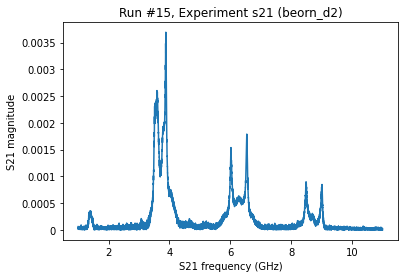

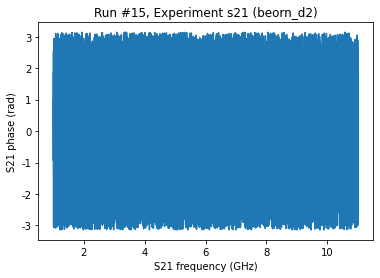

In [19]:
experiment_name = 's21'
measurement_name = 'vna_1dtrce_p0dbm_cnt6ghz_spn10ghz'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

s21.center(6e9)
s21.span(10e9)
# s21.start(2e9)
# s21.stop(10e9)
s21.npts(10001)
s21.bandwidth(1e3)
s21.averaging_enabled(True)
s21.avg(10)
# 30dB of attenuation added at the output
s21.power(-15)

s21.set_electrical_delay_auto()
s21.average_clear()
# ad.go_to_zero()

# turn off
mw_source.status('OFF')
ad.go_to_zero()
I_source.current(0.0)


vna.rf_on()
res = do0d(s21.trace_mag_phase, measurement_name=measurement_name);
vna.rf_off()

res[0].captured_run_id

<h4  style="color:#4697E8";>Phase and magnitude of traces corresponding to different power levels</h4>

Starting experimental run with id: 8. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/31 [00:00<?, ?it/s]

8

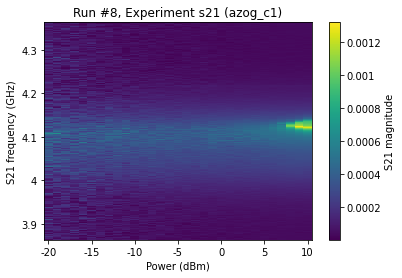

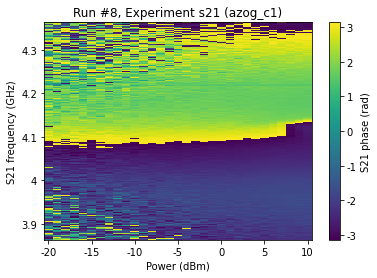

In [37]:
experiment_name = 's21'
measurement_name = 'vna_2dtrce_413ghz_vs_p'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

s21.center(4.113e9)
s21.span(500e6)
# s21.start(2e9)
# s21.stop(10e9)
s21.npts(2001)
s21.bandwidth(1e3)
s21.averaging_enabled(True)
s21.avg(5)
# 30dB of attenuation added at the output

vna.rf_on()
res = do1d(s21.power, -20, 10, 31, 0.01, s21.trace_mag_phase, measurement_name=measurement_name);
vna.rf_off()

res[0].captured_run_id

<h4  style="color:#4697E8";>Phase and magnitude of traces vs flux</h4>

Starting experimental run with id: 1. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/101 [00:00<?, ?it/s]

1

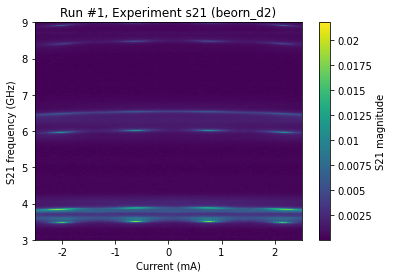

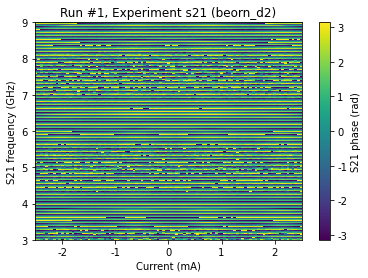

In [89]:
experiment_name = 's21'
measurement_name = 'vna_zeroed_2dtrce_3-9ghz_vs_flux'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

s21.start(3e9)
s21.stop(9e9)
s21.power(-20)
s21.npts(4001)
s21.bandwidth(1e3)
s2v1.averaging_enabled(True)
s21.avg(10)
# 30dB of attenuation added at the output
I_source.current(0.0)

vna.rf_on()
res = do1d(I_source.current, -2.5e-3, 2.5e-3, 101, 0.01, s21.trace_mag_phase, measurement_name=measurement_name);
vna.rf_off()

res[0].captured_run_id

<h4  style="color:#4697E8";>Phase and magnitude of traces vs DC bias</h4>

In [29]:
experiment_name = 's21_vs_dc'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [30]:
adVbias = Parameter(name='adwin_output1',
                    label='Adwin output voltage',
                    unit= 'V',
                    vals=validators.Numbers(-10,10),
                    get_cmd=None,
                    set_cmd=None
                   )

In [31]:
measurement_name = 's21_vs_dc_p6V_2'
meas = qc.Measurement(exp=exp, station=STATION, name=measurement_name)

# mw
# f = 4.04e9
# p = -5.5
# mw_source.frequency(f)
# mw_source.power(p)

s21.start(3e9)
s21.stop(9e9)
s21.power(-20)
s21.npts(10001)

s21.bandwidth(1e3)
s21.averaging_enabled(True)
s21.avg(5)
# 20dB of attenuation added at the output
s21.bandwidth(1e3)

# s21.set_electrical_delay_auto()
s21.average_clear()

ad.input_mask(0b1)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()

VT = 6
Ib = 6.5e-3
offset = 3
ad_Vs = np.linspace(-VT+offset,VT+offset, num=501)

meas.register_parameter(adVbias)
meas.register_parameter(s21.trace_mag_phase, setpoints=[adVbias])


# turn off
mw_source.status('OFF')
ad.go_to_zero()
I_source.current(Ib)

vna.rf_on()

with meas.run() as datasaver :
    for v_ad in tqdm.tqdm(ad_Vs):
        adwin_target = np.array([v_ad, v_ad])
        ad.outputs(adwin_target)
        ad.launch_measurement()
        ad.clear_fifos()
        
        trace = s21.trace_mag_phase()
        datasaver.add_result((adVbias, v_ad),
                             (s21.trace_mag_phase, trace))

vna.rf_off()
ad.clear_fifos()
ad.go_to_zero()
I_source.current(0.0)

# res[0].captured_run_id

Starting experimental run with id: 8. 


  0%|          | 0/501 [00:00<?, ?it/s]

<h3 style="color:#418FDB";>VNA trace and microwave tone</h3>

<h4  style="color:#4697E8";>VNA CW and signal generator power and frequency sweep (two tones spectroscopy)</h4>

In [76]:
experiment_name = 'two_tones'
measurement_name = 'meas_6.24_tone_0.1_25ghz_to_40ghz_long'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

#set the vna parameters
s21.npts(1)
s21.center(6.2485e9)
s21.bandwidth(1e2)
#s21.span(1e3)
s21.averaging_enabled(True)
s21.avg(1)
s21.power(-5)
#s21.set_electrical_delay_auto()

# set the signal generator parameters
mw_source.sourcemode('CW')
mw_source.phase(0)

start_frequency = 25e9
stop_frequency = 40e9
step_frequency = 10e6
frequency_points = int( (stop_frequency-start_frequency)/step_frequency )

start_power = 9
stop_power = 10
step_power = 1
power_points = int( (stop_power-start_power)/step_power )

dwell_time = 0.005

I_source.current(0.0)
ad.go_to_zero()

# WARNING! It takes too much time for some reasons
vna.rf_on()
mw_source.status('ON')
res = do2d(mw_source.power, start_power, stop_power, power_points, dwell_time,
           mw_source.frequency, start_frequency, stop_frequency, frequency_points, dwell_time, 
           s21.trace_mag_phase, measurement_name=measurement_name, do_plot=False);
mw_source.status('OFF')
vna.rf_off()

Starting experimental run with id: 14. Using 'qcodes.utils.dataset.doNd.do2d'


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

<h4  style="color:#4697E8";>Phase and magnitude of traces with mw tone vs mw frequency</h4>

Starting experimental run with id: 15. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/251 [00:00<?, ?it/s]

15

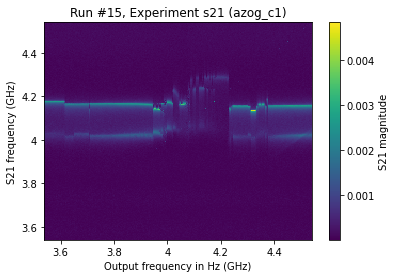

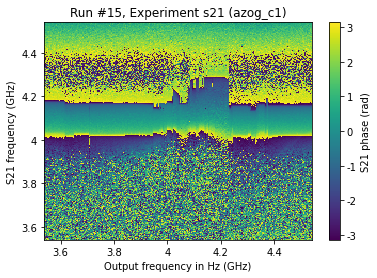

In [34]:
experiment_name = 's21'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

# mw
f = 4.04e9
df = 500e6
p = -7
measurement_name = 'vna_2dtrce_dc2_fcnt' + str(int(f/1e7)) + '_p'  + str(int(p*10))

# voltage adwin
v_ad = 2.2
ad.go_to_zero()
adwin_target = np.array([v_ad, v_ad])
ad.outputs(adwin_target)
ad.launch_measurement()
ad.clear_fifos()

# vna
s21.center(f)
s21.span(1e9)
s21.power(0)
s21.npts(2501)
s21.bandwidth(10e3)
s21.averaging_enabled(True)
s21.avg(2)
# 30dB of attenuation added at the output
I_source.current(0.0)

vna.rf_on()
mw_source.power(p)
mw_source.status('ON')
res = do1d(mw_source.frequency, f-df, f+df, 251, 0.01, s21.trace_mag_phase, measurement_name=measurement_name);
mw_source.status('OFF')
vna.rf_off()

res[0].captured_run_id

<h4  style="color:#4697E8";>Phase and magnitude of traces with mw tone vs mw power</h4>

Starting experimental run with id: 4. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/80 [00:00<?, ?it/s]

4

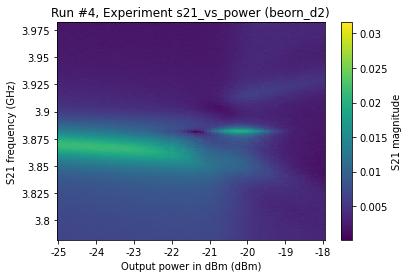

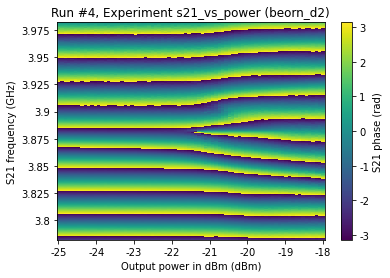

In [111]:
experiment_name = 's21_vs_power'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

frequencies = [ 3.20e9, 4.04e9, 5.45e9, 6.11e9, 6.46e9 ]
powers = [ -11.1, -5.1, 2.9, 3.6, 3.8 ]

# for index in range( len(frequencies) ):
#     # mw
#     f = frequencies[index]
#     p_low = powers[index] - 20
#     p_high = powers[index] + 5
    

# voltage adwin
v_ad = 0
ad.go_to_zero()
adwin_target = np.array([v_ad, v_ad])
ad.outputs(adwin_target)
ad.launch_measurement()
ad.clear_fifos()
time.sleep(1)

f=3.882e9
p_low = -25
p_high = -18
    # vna
s21.center(f)
s21.span(2e8)
s21.power(-20)
s21.npts(2501)
s21.bandwidth(1e3)
s21.averaging_enabled(True)
s21.avg(2)
# 30dB of attenuation added at the output
I_source.current(0.65e-3)



measurement_name = 'vna_2dtrce_adV' + str(v_ad) + '_f' + str(int(f/1e7)) + '_phigh'  + str(int(p_high)) + 'dBm'
vna.rf_on()
mw_source.frequency(f)
mw_source.status('ON')
res = do1d(mw_source.power, p_low, p_high, 80, 0.01, s21.trace_mag_phase, measurement_name=measurement_name);
mw_source.status('OFF')
vna.rf_off()
I_source.current(0e-3)

res[0].captured_run_id

<h4  style="color:#4697E8";>Phase and magnitude of traces with mw tone vs DC bias</h4>

In [58]:
experiment_name = 'vna_bloch_osc'
measurement_name = 'vna_2dtrace_mwon_dcbias'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [59]:
adVbias = Parameter(name='adwin_output1',
                    label='Adwin output voltage',
                    unit= 'V',
                    vals=validators.Numbers(-10,10),
                    get_cmd=None,
                    set_cmd=None
                   )

In [66]:

# mw
f = 4.04e9
p = -5.1
mw_source.frequency(f)
mw_source.power(p)

s21.center(4.75e9)
s21.span(500e6)
s21.npts(2501)
s21.bandwidth(1e4)
s21.averaging_enabled(True)
s21.avg(10)
# 30dB of attenuation added at the output
s21.power(0)

# s21.set_electrical_delay_auto()
s21.average_clear()

ad.input_mask(0b1)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()

VT = 0.5
I = 0e-3
offset = 2.5
I_source.current(I)
ad_Vs = np.linspace(-VT+offset,VT+offset, num=100)

meas_name = 'vna_trace_500MHzspan_center4.75Ghz_mwON_vs_dc_bias_pm5'
meas = qc.Measurement(exp=exp, station=STATION, name=meas_name)

meas.register_parameter(adVbias)
meas.register_parameter(s21.trace_mag_phase, setpoints=[adVbias])

vna.rf_on()
mw_source.status('ON')

with meas.run() as datasaver :
    for v_ad in tqdm.tqdm(ad_Vs):
        adwin_target = np.array([v_ad, v_ad])
        ad.outputs(adwin_target)
        ad.launch_measurement()
        ad.clear_fifos()
        
        trace = s21.trace_mag_phase()
        datasaver.add_result((adVbias, v_ad),
                             (s21.trace_mag_phase, trace))

mw_source.status('OFF')
vna.rf_off()
ad.clear_fifos()
ad.go_to_zero()
I_source.current(0.0)

# res[0].captured_run_id

Starting experimental run with id: 37. 


  0%|          | 0/100 [00:00<?, ?it/s]

<h4  style="color:#4697E8";>Phase and magnitude of traces with mw tone vs flux</h4>

Starting experimental run with id: 36. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/81 [00:00<?, ?it/s]

36

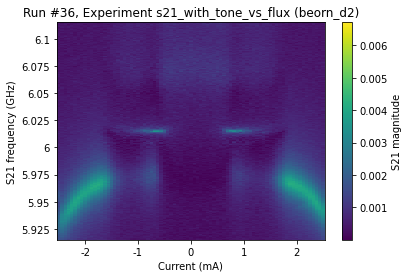

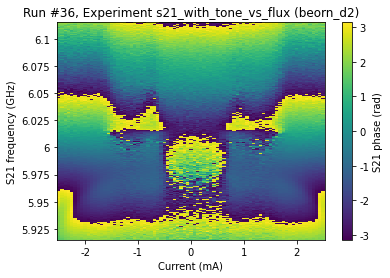

In [53]:
experiment_name = 's21_with_tone_vs_flux'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

# mw
f = 6.015e9
p = -14.7
measurement_name = 'vna_2dtrce_fluxsweep_f' + str(int(f/1e7)) + '_p'  + str(int(p)) + 'dBm'

# vna
s21.center(f)
s21.span(200e6)
s21.power(-20)
s21.npts(2501)
s21.bandwidth(1e3)
s21.averaging_enabled(True)
s21.avg(5)
# 30dB of attenuation added at the output
I_source.current(0.0)

vna.rf_on()
mw_source.frequency(f)
mw_source.power(p)
mw_source.status('ON')
res = do1d(I_source.current, -2.5e-3, 2.5e-3 , 81, 0.01, s21.trace_mag_phase, measurement_name=measurement_name);
mw_source.status('OFF')
vna.rf_off()

res[0].captured_run_id

<h3  style="color:#418FDB";>IV curves</h3>

<h4 style="color:#4697E8";>Simple IV</h4>

In [47]:
experiment_name = 'iv_curves'
# measurement_name = "iv_mwon_5cnoavg_step_zoom_p002_1501pts"
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [51]:
ad.input_mask(0b11)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()
VT = 5.0
offset = 5
ramp_param = ADwin_averagedRamp('simple_iv1',
                        ad, 
                        period=0.2, 
                        n_pts=10001,
                        N_ramp=1,
                        Vs_high=np.array([VT+offset, -VT+offset]),
                        Vs_low=np.array([-VT+offset, VT+offset]),
                        progress= True)

easy_iv = ADwin_IV(ramp_param.name+'_iv', ramp_param,
                  voltage_input=2,
                  current_input=1,
                  voltage_divider_value=1e3,
                  current_coefficient=1e8)

In [52]:

# frequencies = [ 3.20e9, 4.04e9, 5.45e9, 6.11e9, 6.46e9 ]
# powers = [ -11.1, -5.1, 2.9, 3.6, 3.8 ]


# # mw
# k = 4
# f =frequencies[k]
# p = powers[k]

Ib = 0e-3
    
measurement_name = 'iv_period%.2f_V%.1f_N%i' % (ramp_param.half_period*2, VT+offset, ramp_param.N_ramp)
meas = qc.Measurement(exp=exp, station=STATION, name = measurement_name)

# flux
I_source.current(Ib)

# turn off
mw_source.status('OFF')
ad.go_to_zero()
I_source.current(0.0)

# logging
meas.register_parameter(easy_iv)
meas.write_period = 10

# measurement
with meas.run() as datasaver:
    get_iv = easy_iv() 
    datasaver.add_result((easy_iv, get_iv))

# turn off
mw_source.status('OFF')
ad.go_to_zero()
I_source.current(0.0)

Starting experimental run with id: 3. 


  0%|          | 0/2 [00:00<?, ?it/s]

<h4 style="color:#4697E8";>Adwin and fixed tone</h4>

In [19]:
experiment_name = 'iv_curves'
# measurement_name = "iv_mwon_5cnoavg_step_zoom_p002_1501pts"
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [21]:
ad.input_mask(0b11)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()
VT = 3.0
offset = 0
ramp_param = ADwin_averagedRamp('simple_iv8',
                        ad, 
                        period=0.2, 
                        n_pts=10001,
                        N_ramp=10,
                        Vs_high=np.array([VT+offset, -VT+offset]),
                        Vs_low=np.array([-VT+offset, VT+offset]),
                        progress= True)

easy_iv = ADwin_IV(ramp_param.name+'_iv', ramp_param,
                  voltage_input=2,
                  current_input=1,
                  voltage_divider_value=1e3,
                  current_coefficient=1e8)

In [22]:

# frequencies = [ 3.20e9, 4.04e9, 5.45e9, 6.11e9, 6.46e9 ]
# powers = [ -11.1, -5.1, 2.9, 3.6, 3.8 ]


# # mw
# k = 4
# f =frequencies[k]
# p = powers[k]

f = 3.829e9
p = -18.5
Ib = 0e-3
    
measurement_name = 'iv_mwon_f%.2e_pm%.2f_standard' % (f, p)
meas = qc.Measurement(exp=exp, station=STATION, name = measurement_name)

# flux
I_source.current(Ib)

# mw
mw_source.power(p)
mw_source.frequency(f)
mw_source.status('ON')

# logging
meas.register_parameter(mw_source.frequency)
meas.register_parameter(mw_source.power)
meas.register_parameter(easy_iv)
meas.write_period = 10

# measurement
with meas.run() as datasaver:
    get_iv = easy_iv() 
    datasaver.add_result((easy_iv, get_iv))

# turn off
mw_source.status('OFF')
ad.go_to_zero()
I_source.current(0.0)

Starting experimental run with id: 1. 


  0%|          | 0/20 [00:00<?, ?it/s]

<h4 style="color:#4697E8";>Adwin vs flux</h4>

In [70]:
experiment_name = 'iv_curves'
measurement_name = 'iv_pm166mV_phimp5ma_100kpts_1avg'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [71]:
ad.input_mask(0b11)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()
VT = 5
offset = 0
ramp_param = ADwin_averagedRamp(measurement_name.replace('.', '_'),
                        ad, 
                        period=30.1,
                        n_pts=100001,
                        N_ramp=1,
                        Vs_high=np.array([VT+offset, -VT+offset]),
                        Vs_low=np.array([-VT+offset, VT+offset]),
                        progress= False)

easy_iv = ADwin_IV(ramp_param.name+'_iv', ramp_param,
                  voltage_input=2,
                  current_input=1,
                  voltage_divider_value=1e3,
                  current_coefficient=1e8)

In [72]:
meas = qc.Measurement(exp=exp, station=STATION, name=measurement_name)

# p=0
# f=6e8

#MW source
# mw_source.power(p)
# mw_source.frequency(f)

# flux
I_min = -5e-3
I_max = 5e-3
I_num = 201
currents = np.linspace(I_min, I_max, I_num)

# logging
meas.register_parameter(I_source.current)
meas.register_parameter(easy_iv, setpoints=[I_source.current])
meas.write_period = 10

# measurement
mw_source.status('OFF')
with meas.run() as datasaver:
    for I in tqdm.tqdm(currents):
        I_source.current(I)
        get_iv = easy_iv() 

        datasaver.add_result((easy_iv, get_iv),
                             (I_source.current, I))

mw_source.status('OFF')
I_source.current(0)

Starting experimental run with id: 42. 


  0%|          | 0/201 [00:00<?, ?it/s]

<h4 style="color:#4697E8";>Adwin vs tone frequency</h4>

In [50]:
experiment_name = 'iv_curves'
measurement_name = "iv_step3ghz_p008_7001pts_201avg"
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [51]:
ad.input_mask(0b11)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()
VT = 0.2
offset = 2
ramp_param = ADwin_averagedRamp(measurement_name, 
                        ad, 
                        period=0.08, 
                        n_pts=7001,
                        N_ramp=201,
                        Vs_high=np.array([VT+offset, -VT+offset]),
                        Vs_low=np.array([-VT+offset, VT+offset]),
                        progress= False)

easy_iv = ADwin_IV(ramp_param.name+'_iv', ramp_param,
                  voltage_input=2,
                  current_input=1,
                  voltage_divider_value=1e3,
                  current_coefficient=1e9)

In [30]:
meas = qc.Measurement(exp=exp, station=STATION, name = measurement_name)

# flux
I_source.current(0e-3)

# mw power and frequency sweep
pwr = -11
# frequency = 3.16e9
# frequency_array = np.linspace(frequency - 50e6, frequency + 50e6, num=101)
frequency_array = np.linspace( 4.04e9, 4.1e9,  num=101)
mw_source.status('ON')

# logging
meas.register_parameter(mw_source.frequency)
meas.register_parameter(mw_source.power)
meas.register_parameter(easy_iv, setpoints=[mw_source.frequency, mw_source.power])
meas.write_period = 10

with meas.run() as datasaver:

    for frq in tqdm.tqdm(frequency_array):
        # VNA.channels.S21.power(pow)
        mw_source.frequency(frq)
        mw_source.power(pwr)
        get_iv = easy_iv() 

        datasaver.add_result((easy_iv, get_iv),
                             (mw_source.frequency, frq),
                             (mw_source.power, pwr))

    I_source.current(0)
    
mw_source.status('OFF')

Starting experimental run with id: 8. 


  0%|          | 0/101 [00:00<?, ?it/s]

<h4 style="color:#4697E8";>Adwin vs tone power</h4>

In [54]:
experiment_name = 'iv_w_steps_power_sweep'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [55]:
ad.input_mask(0b11)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()
VT = 0.5
offset = 0.0
ramp_param = ADwin_averagedRamp("iv_steps_pwr_sweep_10", 
                        ad, 
                        period=0.05, 
                        n_pts=4001,
                        N_ramp=100,
                        Vs_high=np.array([VT+offset, -VT+offset]),
                        Vs_low=np.array([-VT+offset, VT+offset]),
                        progress= False)

easy_iv = ADwin_IV(ramp_param.name+'_iv', ramp_param,
                  voltage_input=2,
                  current_input=1,
                  voltage_divider_value=1e3,
                  current_coefficient=1e9)

In [58]:
f = 6.012e9
p_number = 1001

measurement_name = 'iv_steps_f' + str(int(f/1e7)) + '_pwr_sweep'
meas = qc.Measurement(exp=exp, station=STATION, name = measurement_name)

# flux
I_source.current(0.65e-3)

# mw power and frequency sweep
frequency = f 
# pmin = p - dp
# pmax = p + dp
pmin = -18
pmax = -13


power_array = np.linspace(pmin, pmax, num=p_number)
mw_source.status('ON')

# logging
meas.register_parameter(mw_source.frequency)
meas.register_parameter(mw_source.power)
meas.register_parameter(easy_iv, setpoints=[mw_source.frequency, mw_source.power])
meas.write_period = 10

with meas.run() as datasaver:

    for pwr in tqdm.tqdm(power_array):
        # VNA.channels.S21.power(pow)
        mw_source.frequency(frequency)
        mw_source.power(pwr)
        time.sleep(0.05)
        get_iv = easy_iv() 

        datasaver.add_result((easy_iv, get_iv),
                             (mw_source.frequency, frequency),
                             (mw_source.power, pwr))

        
I_source.current(0)
mw_source.status('OFF')

Starting experimental run with id: 39. 


  0%|          | 0/1001 [00:00<?, ?it/s]

<h4 style="color:#4697E8";>Adwin with mw tone vs flux</h4>

In [43]:
experiment_name = 'iv_curves_flux_2'
measurement_name = "iv_step_6_0ghz_p21_10001pts_10avg_zoomed2"
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [44]:
ad.input_mask(0b11)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()
VT = 0.5
offset = 0
ramp_param = ADwin_averagedRamp(measurement_name, 
                        ad, 
                        period=0.05, 
                        n_pts=4001,
                        N_ramp=10,
                        Vs_high=np.array([VT+offset, -VT+offset]),
                        Vs_low=np.array([-VT+offset, VT+offset]),
                        progress= False)

easy_iv = ADwin_IV(ramp_param.name+'_iv', ramp_param,
                  voltage_input=2,
                  current_input=1,
                  voltage_divider_value=1e3,
                  current_coefficient=1e9)

In [45]:
meas = qc.Measurement(exp=exp, station=STATION, name=measurement_name)

# flux
currents = np.linspace(-10e-3,  10e-3, num=151)

# mw
# f = 3.882e9
# p = -20.5
f = 6.012e9
p = -15
mw_source.frequency(f)
mw_source.power(p)
mw_source.status('ON')

# logging
meas.register_parameter(I_source.current)
meas.register_parameter(easy_iv, setpoints=[I_source.current])
meas.write_period = 10

# measurement
with meas.run() as datasaver:
    for I in tqdm.tqdm(currents):
        I_source.current(I)
        get_iv = easy_iv() 

        datasaver.add_result((easy_iv, get_iv),
                             (I_source.current, I))
        
mw_source.status('OFF')
I_source.current(0)

Starting experimental run with id: 12. 


  0%|          | 0/151 [00:00<?, ?it/s]

<h4 style="color:#4697E8";>Adwin ramp statistics</h4>

In [20]:
ad.input_mask(0b11)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()
VT = 2
offset = 3
ramp_param = ADwin_averagedRamp("avg_ramp_statistics2",
                        ad, 
                        period=0.2, 
                        n_pts=501,
                        N_ramp=11,
                        Vs_high=np.array([VT+offset, -VT+offset]),
                        Vs_low=np.array([-VT+offset, VT+offset]),
                        progress= False)

easy_iv = ADwin_IV(ramp_param.name+'_iv', ramp_param,
                  voltage_input=2,
                  current_input=1,
                  voltage_divider_value=1e3,
                  current_coefficient=1e9)

tokenParameter = Parameter(name='ramp_number2',
                    label='Number of the ramp',
                    unit= '',
                    vals=validators.Numbers(0,1e5),
                    get_cmd=None,
                    set_cmd=None
                   )


experiment_name = 'iv_curves'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [23]:
f = 4.04e9
p = -5.1

Ib = 0.0
N_avg_ramps = 10000


meas = qc.Measurement(exp=exp, station=STATION, name='iv_mwon_f404p-55_stat_sweep')

mw_source.frequency(f)
mw_source.power(p)
mw_source.status('ON')

I_source.current(Ib)


# logging

meas.register_parameter(tokenParameter)
meas.register_parameter(easy_iv, setpoints=[tokenParameter])
meas.write_period = 10

# measurement
with meas.run() as datasaver:
    for k in tqdm.tqdm(range(N_avg_ramps)):
        # I_source.current(I)
        get_iv = easy_iv() 

        datasaver.add_result((easy_iv, get_iv),
                             (tokenParameter, k))
        
mw_source.status('OFF')
I_source.current(0)

Starting experimental run with id: 4. 


  0%|          | 0/10000 [00:00<?, ?it/s]

<h3  style="color:#4697E8";>Spectrum analyser</h3>

<h4 style="color:#4697E8";>Spectrum analyser vs DC bias (searching sidebands)</h4>

In [55]:
experiment_name = 'trace_spectrum_analyser'
measurement_name = '1dtrace_sa'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

meas = qc.Measurement(exp=exp, station=STATION, name=measurement_name)


# spectrum analyser setup
spectrum_analyser.center_freq(4.113e9)
spectrum_analyser.span(4e9)
spectrum_analyser.n_points(10001)
spectrum_analyser.res_BW(1e4)

# spectrum_analyser.average_type('pow')
spectrum_analyser.averages(5)

# adwin setup
ad.input_mask(0b1)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()
VT = 71
I = 5e-3
offset = 2.67

# mw source
mw_source.power(-30)
mw_source.frequency(4.113e9)

I_source.current(I)
ad_Vs = np.linspace(-VT+offset,VT+offset, num=1000)
background = spectrum_analyser.spectrum()

meas.register_parameter(adVbias)
meas.register_parameter(spectrum_analyser.spectrum, setpoints=[adVbias])

mw_source.status('ON')

with meas.run() as datasaver :
    for v_ad in tqdm.tqdm(ad_Vs):
        adwin_target = np.array([v_ad, v_ad])
        ad.outputs(adwin_target)
        ad.launch_measurement()
        ad.clear_fifos()
        
        trace = spectrum_analyser.spectrum() - background
        datasaver.add_result((adVbias, v_ad),
                             (spectrum_analyser.spectrum, trace))

ad.clear_fifos()
ad.go_to_zero()
mw_source.status('OFF')

I_source.current(0.0)

Starting experimental run with id: 9. 


  0%|          | 0/1000 [00:00<?, ?it/s]

<h4 style="color:#4697E8";>Signal hound</h4>

In [23]:
experiment_name = 'tone_sidebands'
measurement_name = 'mw_tone_p-5dbm_f4.04ghz_modon'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [21]:
f = 4.04e9

sh.frequency(f + 100)
sh.span(5e6) # rbw?
sh.rbw(300)
sh.vbw(300)
sh.avg(1)
sh.configure()
tt = sh.trace()

In [22]:
tt

array([-103.38461304, -106.52218628, -103.34850311, ..., -100.92845917,
       -102.3098526 , -102.5214386 ])

Starting experimental run with id: 5. Using 'qcodes.utils.dataset.doNd.do0d'


(results #5@D:\QMET\azog_c1\20220203_ncr_spectrumanalyzer_BO_v1.db
 -----------------------------------------------------------------
 signal_hound2_frequency - array
 signal_hound2_trace - array,
 [<AxesSubplot:title={'center':'Run #5, Experiment bo_sidebands_pump (azog_c1)'}, xlabel='Frequency (GHz)', ylabel='Magnitude (dBm)'>],
 [None])

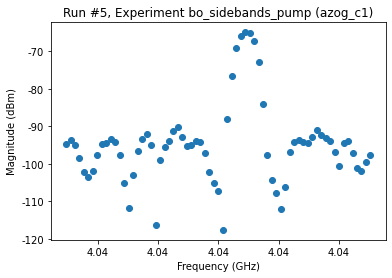

In [19]:
f = 4.04e9

sh.frequency(f + 100)
sh.span(500) # rbw?
sh.rbw(30)
sh.vbw(30)
sh.avg(1)


#Modulation 
mw_source.power(-5)
mw_source.frequency(f)
mw_source.status('ON')

# lock-in source parameters
# li.frequency(100.1)  # Hz
# li.amplitude(0.4) # V

sh.configure()
do0d(sh.trace)

<h4 style="color:#4697E8";>Signal hound VS MW power</h4>

In [17]:
experiment_name = 'bo_sidebands_pump'

exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [16]:
adVbias = Parameter(name='adwin_output1',
                    label='Adwin output voltage in current',
                    unit= 'A',
                    vals=validators.Numbers(-10,10),
                    get_cmd=None,
                    set_cmd=None
                   )

Starting experimental run with id: 4. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/100 [00:00<?, ?it/s]

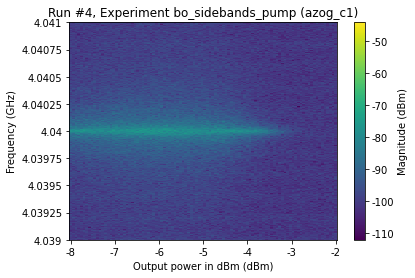

In [21]:
f = 4.04e9

sh.frequency(f)
sh.span(2e6) # rbw?
sh.rbw(300)
sh.vbw(300)
sh.avg(10)

# voltage adwin
v_ad = 1.7
ad.go_to_zero()
adwin_target = np.array([v_ad, v_ad])
ad.outputs(adwin_target)
ad.launch_measurement()
ad.clear_fifos()
time.sleep(1)

p_low = -8
p_high = -2
mw_source.frequency(f)

# lock-in source parameters
# li.frequency(100.1)  # Hz
# li.amplitude(0.4) # V
measurement_name = 'mw_tone_powersweep_f4.04ghz_vAd' + str(v_ad)
sh.configure()


mw_source.status('ON')
res = do1d(mw_source.power, p_low, p_high, 100, 0.01, sh.trace, measurement_name=measurement_name);
mw_source.status('OFF')

<h4 style="color:#4697E8";>Signal Hound vs DC bias (searching BO)</h4>

In [37]:
experiment_name = 'trace_spectrum_analyser_VS_DCcurrentBias_larger'
measurement_name = '1dtrace_sa'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

meas = qc.Measurement(exp=exp, station=STATION, name=measurement_name)


# spectrum analyser setup
sh.frequency(1e9)
sh.span(2e6) # rbw?
sh.rbw(3000)
sh.vbw(3000)
sh.avg(10)
sh.configure()
# adwin setup
ad.input_mask(0b1)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()


VT = 1.5
I = 0e-3
offset =  4.5
e = 1.602e-19

I_source.current(I)
ad_Vs = np.linspace(-VT+offset,VT+offset, num=100)

meas.register_parameter(adVbias)
meas.register_parameter(sh.trace, setpoints=[adVbias])

mw_source.status('OFF')

with meas.run() as datasaver :
    for v_ad in tqdm.tqdm(ad_Vs):
        
        current = v_ad/30/1e8
        
        sh.frequency(current/2/e)
        sh.configure()
        
        ad.go_to_zero()
        background = sh.trace()
        
        adwin_target = np.array([v_ad, v_ad])
        ad.outputs(adwin_target)
        ad.launch_measurement()
        ad.clear_fifos()
        
        
        
        trace = sh.trace() - background
        datasaver.add_result((adVbias, current),
                             (sh.trace, trace))

ad.clear_fifos()
ad.go_to_zero()
mw_source.status('OFF')

I_source.current(0.0)

Starting experimental run with id: 19. 


  0%|          | 0/100 [00:00<?, ?it/s]

<h3 style="color:#4697E8";>Lock-in amplifier</h3>

<h4 style="color:#4697E8";>IV curve</h4>

In [30]:
experiment_name = 'dIdV'
measurement_name = 'dIdV_pm3V_f211_tau0.1s_0flux_rampdown'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [35]:
frequency = 211

# first output used to modulate the signal sent to the sample
afg.voltage_amplitude1(0.01)
afg.voltage_offset1(0)
afg.impedance_output1(10e3)

# second output used to trigger the lock-in
afg.voltage_amplitude2(1)
afg.voltage_offset2(0)

afg.freq_cw1(frequency)
afg.freq_cw2(frequency)

# synch the two
afg.synchronize_phase(0)

Starting experimental run with id: 4. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/2001 [00:00<?, ?it/s]

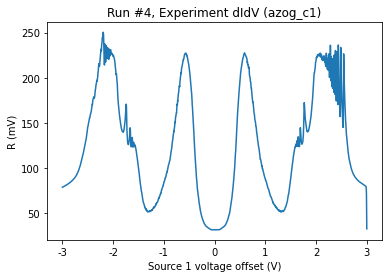

In [33]:
tau = 100e-3
vmin = -3
vmax = 3
n_points = 2001
I_source.current(0.0)

li.time_constant(tau)  # s

afg.state_output1('ON')
afg.state_output2('ON')
do1d(afg.voltage_offset1, vmax, vmin, n_points, tau, li.R)
afg.state_output1('OFF')
afg.state_output2('OFF')

<h4 style="color:#4697E8";>IV curve and flux</h4>

In [19]:
experiment_name = 'dIdV_flux'
measurement_name = 'dIdV_flux_pm05V_f211_tau0.1s_rampup'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [20]:
# measurement frequency
frequency = 211

# first output used to modulate the signal sent to the sample
afg.voltage_amplitude1(0.1)
afg.voltage_offset1(0)
afg.impedance_output1(10e3)

# second output used to trigger the lock-in
afg.voltage_amplitude2(1)
afg.voltage_offset2(0)

afg.freq_cw1(frequency)
afg.freq_cw2(frequency)

# synch the two
afg.synchronize_phase(0)

Starting experimental run with id: 17. Using 'qcodes.utils.dataset.doNd.do2d'


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

2022-06-22 12:56:31,275 ¦ qcodes.dataset.measurements ¦ WARNING ¦ measurements ¦ __exit__ ¦ 646 ¦ An exception occured in measurement with guid: aaaaaaaa-0000-0000-0000-01818ae8ca33;
Traceback:
Traceback (most recent call last):
  File "C:\Users\nicolas.roch\Measurements\Scripts\QMETfunc\QMET_measurement.py", line 448, in do2d
    param_set2.set(set_point2)
  File "C:\Users\nicolas.roch\Miniconda3\envs\measurement\lib\site-packages\qcodes\instrument\parameter.py", line 690, in set_wrapper
    set_function(raw_val_step, **kwargs)
  File "C:\Users\nicolas.roch\Miniconda3\envs\measurement\lib\site-packages\qcodes\utils\command.py", line 180, in __call__
    return self.exec_function(*args)
  File "C:\Users\nicolas.roch\Miniconda3\envs\measurement\lib\site-packages\qcodes\utils\command.py", line 129, in call_by_str
    return self.exec_str(self.cmd_str.format(*args))
  File "C:\Users\nicolas.roch\Miniconda3\envs\measurement\lib\site-packages\qcodes\instrument\base.py", line 756, in write
 

Received SIGINT, Will interrupt at first suitable time. Send second SIGINT to interrupt immediately.


KeyboardInterrupt: 

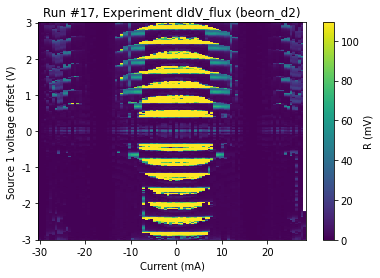

In [21]:
tau = 10e-3
vmin = -3
vmax = 3
n_points = 501

phimin = -30e-3
phimax = 30e-3
Ipoints = 101
I_source.current(0.0)

li.time_constant(tau)  # s

afg.state_output1('ON')
afg.state_output2('ON')

do2d(I_source.current, phimin, phimax, Ipoints, 0.01, afg.voltage_offset1, vmin, vmax, n_points, tau, li.R)

afg.state_output1('OFF')
afg.state_output2('OFF')
I_source.current(0.0)

In [22]:
experiment_name = 'dIdV_flux'
measurement_name = 'dIdV_flux_pm05V_mwon_f211_tau0.1s_rampup'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [23]:
# measurement frequency
frequency = 211

# first output used to modulate the signal sent to the sample
afg.voltage_amplitude1(0.1)
afg.voltage_offset1(0)
afg.impedance_output1(10e3)

# second output used to trigger the lock-in
afg.voltage_amplitude2(1)
afg.voltage_offset2(0)

afg.freq_cw1(frequency)
afg.freq_cw2(frequency)

# synch the two
afg.synchronize_phase(0)

Starting experimental run with id: 18. Using 'qcodes.utils.dataset.doNd.do2d'


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

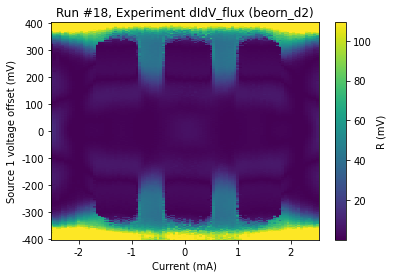

In [25]:
f = 3.88e9
p = -20.9
Ib = 0.e-3

mw_source.frequency(f)
mw_source.power(p)
I_source.current(Ib)

phimin = -2.5e-3
phimax = 2.5e-3
Ipoints = 101

vmin = -0.4
vmax = 0.4
n_points = 201
I_source.current(Ib)

mw_source.status('ON')

afg.state_output1('ON')
afg.state_output2('ON')
do2d(I_source.current, phimin, phimax, Ipoints, 0.01, afg.voltage_offset1, vmin, vmax, n_points, tau, li.R)
afg.state_output1('OFF')
afg.state_output2('OFF')

mw_source.status('OFF')

<h4 style="color:#4697E8";>Microwave tone modulation</h4>

In [28]:
experiment_name = 'dIdP'
measurement_name = 'dIdp_adV2.13V_f11_tau10ms_mwf3.20'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [27]:
# lock-in parameters
# the tau is long and the frequency is low because the measurement suffers from 
# low-frequency instability, so to average them out we need to make a looong run.

tau = 10e-3

li.frequency(211)  # Hz
li.amplitude(0.4) # V
li.time_constant(tau)  # s

Starting experimental run with id: 27. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/1501 [00:00<?, ?it/s]

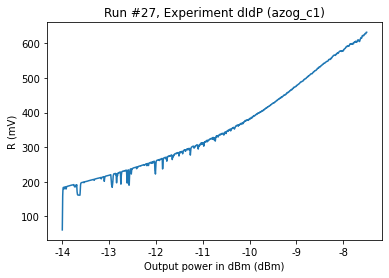

In [54]:
# fixed voltage set with the adwin
v_ad = 0.15

# frequency and power of the microwave tone
# f = 3.882e9

# p = -15.4
f = 6.012e9

pmin = -18
pmax = -10
n_power = 1501
mw_source.frequency(f)


Ib = 0.65e-3
I_source.current(Ib)
# mw_source.power(p)

# turn on the adwin voltage
adwin_target = np.array([v_ad, v_ad])
ad.outputs(adwin_target)
ad.launch_measurement()

mw_source.status('ON')
do1d(mw_source.power, pmin, pmax, n_power, tau, li.R)
mw_source.status('OFF')

ad.clear_fifos()
ad.go_to_zero()

<h4 style="color:#4697E8";>Microwave tone modulation VS DC</h4>

In [38]:
experiment_name = 'mwMod_vs_dc'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [39]:
adVbias = Parameter(name='adwin_output1',
                    label='Adwin output voltage',
                    unit= 'V',
                    vals=validators.Numbers(-10,10),
                    get_cmd=None,
                    set_cmd=None
                   )

In [47]:
meas = qc.Measurement(exp=exp, station=STATION, name=measurement_name)

# flux
ad.input_mask(0b1)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()

VT = 0.3
Ib = 0.65e-3
offset = 0.3


f = 6.012e9
pmin = -20
pmax = -10
nb_power = 101


tau = 100e-3

li.frequency(111)  # Hz
li.amplitude(0.4) # V
li.time_constant(tau)  # s

ad_Vs = np.linspace(-VT+offset,VT+offset, num=101)
powers = np.linspace(pmin , pmax, num=nb_power)


meas.register_parameter(adVbias)
meas.register_parameter(mw_source.power)
meas.register_parameter(li.R, setpoints=[adVbias, mw_source.power])


# turn off
mw_source.frequency(f)
mw_source.status('ON')

ad.go_to_zero()
I_source.current(Ib)


with meas.run() as datasaver :
    for v_ad in tqdm.tqdm(ad_Vs):
        adwin_target = np.array([v_ad, v_ad])
        ad.outputs(adwin_target)
        ad.launch_measurement()
        
        
        for p in powers :
            mw_source.power(p)
            
            time.sleep(tau)
            
            trace = li.R()
            datasaver.add_result((adVbias, v_ad),
                                 (mw_source.power, p),
                                 (li.R, trace))
        ad.clear_fifos()


mw_source.status('OFF')
ad.clear_fifos()
ad.go_to_zero()
I_source.current(0.0)

Starting experimental run with id: 32. 


  0%|          | 0/101 [00:00<?, ?it/s]

<h4 style="color:#4697E8";>Microwave tone modulation VS flux</h4>

In [75]:
experiment_name = 'mwMod_vs_flux'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

Starting experimental run with id: 44. Using 'qcodes.utils.dataset.doNd.do2d'


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

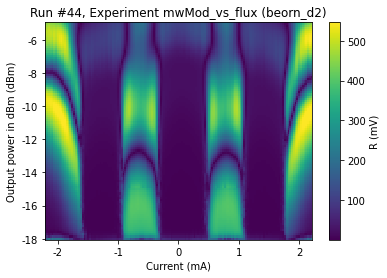

In [76]:
# lock-in parameters
# the tau is long and the frequency is low because the measurement suffers from 
# low-frequency instability, so to average them out we need to make a looong run.

tau = 100e-3

li.frequency(111)  # Hz
li.amplitude(0.4) # V
li.time_constant(tau)  # s

# fixed voltage set with the adwin
v_ad = 0.3

# frequency and power of the microwave tone
# f = 3.882e9

# p = -15.4
f = 6.012e9

pmin = -18
pmax = -5
n_power = 101
mw_source.frequency(f)


Ib = 0
I_source.current(Ib)
I_start = -2.2e-3
I_end = 2.2e-3
I_points = 151
# mw_source.power(p)

# turn on the adwin voltage
adwin_target = np.array([v_ad, v_ad])
ad.outputs(adwin_target)
ad.launch_measurement()

mw_source.status('ON')
do2d(I_source.current, I_start, I_end, I_points, 0.01, mw_source.power, pmin, pmax, n_power, tau, li.R)
mw_source.status('OFF')

ad.clear_fifos()
ad.go_to_zero()

<h4 style="color:#4697E8";>$dI/dV$ vs. $V$ vs. $p$</h4>

In [29]:
experiment_name = 'dIdV_vs_p'
measurement_name = 'dIdV_pm04_m2on_f6_tau100msf1hz'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [30]:
# lock-in parameters
# the tau is long and the frequency is low because the measurement suffers from 
# low-frequency instability, so to average them out we need to make a looong run.

frequency = 11

# first output used to modulate the signal sent to the sample
afg.voltage_amplitude1(0.1)
afg.voltage_offset1(0)
afg.impedance_output1(10e3)

# second output used to trigger the lock-in
afg.voltage_amplitude2(1)
afg.voltage_offset2(0)

afg.freq_cw1(frequency)
afg.freq_cw2(frequency)

# synch the two
afg.synchronize_phase(0)

tau = 100e-3
li.time_constant(tau)  # s

Starting experimental run with id: 24. Using 'qcodes.utils.dataset.doNd.do2d'


  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

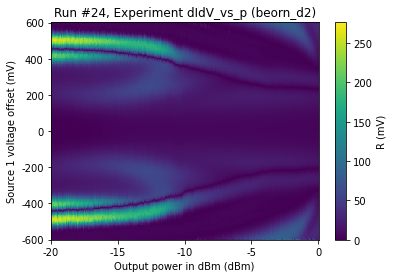

In [31]:
# frequency and power of the microwave tone
# p = -14.5
f = 6.012e9
Ib = 0.65e-3

mw_source.frequency(f)
# mw_source.power(p)

I_source.current(Ib)

vmin = -0.6
vmax = 0.6
n_points = 501

pmin = -20
pmax = 0
n_power = 501

I_source.current(Ib)

mw_source.status('ON')

afg.state_output1('ON')
afg.state_output2('ON')
meas = do2d(mw_source.power, pmin, pmax, n_power, 0.01, afg.voltage_offset1, vmin, vmax, n_points, tau, li.R)
afg.state_output1('OFF')
afg.state_output2('OFF')

mw_source.status('OFF')

# ad.clear_fifos()
# ad.go_to_zero()

<h3  style="color:#4697E8";>Current biasing with a $100\,\mathrm{M\Omega}$ resistor</h3>

In [16]:
experiment_name = 'VI_curves'
measurement_name = 'VI_base'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [22]:
ad.input_mask(0b11)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()

VT = 0.2
offset = 0.00
ramp_param = ADwin_averagedRamp("current_bias_small_IC_10syy", 
                        ad, 
                        period=10,
                        n_pts=10001,
                        N_ramp=1,
                        Vs_high=np.array([VT+offset, VT+offset]),
                        Vs_low=np.array([-VT+offset, -VT+offset]),
                        progress= False)

easy_iv = ADwin_VI(ramp_param.name+'vi', ramp_param,
                  voltage_input=2,
                  current_input=1,
                  current_divider_value=1e8,
                  voltage_coefficient=1e2) # actually voltage coefficient here

<h4 style="color:#4697E8";>VI versus flux</h4>

In [23]:
meas = qc.Measurement(exp=exp, station=STATION, name='vi_fluxsweep')

# flux
currents = np.linspace(-10e-3,  10e-3, num=101)

# logging
meas.register_parameter(I_source.current)
meas.register_parameter(easy_iv, setpoints=[I_source.current])
meas.write_period = 10

# measurement
with meas.run() as datasaver:
    for I in tqdm.tqdm(currents):
        I_source.current(I)
        get_iv = easy_iv() 

        datasaver.add_result((easy_iv, get_iv),
                             (I_source.current, I))
        
I_source.current(0)

Starting experimental run with id: 2. 


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

<h4 style="color:#4697E8";>VNA versus current bias</h4>

In [33]:
experiment_name = 's21'
measurement_name = 's21_vs_current_dc'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

In [34]:
adVbias = Parameter(name='adwin_output1',
                    label='Adwin output voltage converted to current',
                    unit= 'A',
                    vals=validators.Numbers(-10,10),
                    get_cmd=None,
                    set_cmd=None
                   )

In [43]:
meas = qc.Measurement(exp=exp, station=STATION, name='vna_trace_vs_current_bias_4.04GHzmode' )

# mw
f = 4.04e9
p = -5.5
# mw_source.frequency(f)
# mw_source.power(p)

s21.center(f)
s21.span(5e8)
s21.npts(2001)
s21.bandwidth(1e3)
s21.averaging_enabled(True)
s21.avg(1)
# 30dB of attenuation added at the output
s21.power(0)

# s21.set_electrical_delay_auto()
s21.average_clear()

ad.input_mask(0b1)
ad.output_mask(0b11)
ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()

VT = 0.01
I = 0e-3
offset = 0.05
# I_source.current(I)
ad_Vs = np.linspace(offset-VT,VT+offset, num=201)

meas.register_parameter(adVbias)
meas.register_parameter(s21.trace_mag_phase, setpoints=[adVbias])

vna.rf_on()

with meas.run() as datasaver :
    for v_ad in tqdm.tqdm(ad_Vs):
        adwin_target = np.array([v_ad, v_ad])
        ad.outputs(adwin_target)
        ad.launch_measurement()
        ad.clear_fifos()
        
        trace = s21.trace_mag_phase()
        datasaver.add_result((adVbias, v_ad/1e8),
                             (s21.trace_mag_phase, trace))

vna.rf_off()
ad.clear_fifos()
ad.go_to_zero()
# I_source.current(0.0)

# res[0].captured_run_id

Starting experimental run with id: 5. 


  0%|          | 0/201 [00:00<?, ?it/s]

<h2 style="color:#1C3C5C";>Data preview</h2>
Using the experiments widget to look at all the measurements in the database, or filter them by experiment.

In [30]:
#experiments = qc.experiments()                       # define the experiments
#data_sets = experiments[1].data_sets()               # select only one experiment
#experiments_widget(data_sets=data_sets)              # start the widget on the selected experiment

experiments_widget(db=qc.config.core.db_location)  # start the widget on the whole database